In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40231 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/preproc/Haiyan/intermediate/dask-worker-space/worker-0493akxs', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/preproc/Haiyan/intermediate/dask-worker-space/worker-eq3j_ucb', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/preproc/Haiyan/intermediate/dask-worker-space/worker-c35t3731', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/fredd

#### Read

In [2]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/intermediate/'
pcastore = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g')
haiyan_data = read_and_proc.depickle(folderpath+'pca/flatvar'+'_'+'dict2_g')

### Train FFS

##### Random X,y read

In [4]:
def _get_exp_name(splitnum=None,folder=2):
    return sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/Xtrain*'))[splitnum][:-7].split('/')[-1][6:],sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/Xtrain*'))[splitnum][:-7].split('/')[-1][6:].split('_')

def real_random(index=None,folder=2):
    toextract = _get_exp_name(index,folder)[0]
    # X
    Xtestpath,Xtrainpath,Xvalidpath = sorted(glob.glob(folderpath+'pca/X/random/'+str(folder)+'/*'+str(toextract)+'*'))
    Xtest,Xtrain,Xvalid = [read_and_proc.depickle(obj) for obj in[Xtestpath,Xtrainpath,Xvalidpath]]
    # y
    yallpath = sorted(glob.glob(folderpath+'pca/y/random/'+str(folder)+'/*'+str(toextract)+'*'))
    yall = read_and_proc.depickle(yallpath[0])
    return Xtest,Xtrain,Xvalid,yall

In [5]:
for i in tqdm(range(33)):
    print(_get_exp_name(i,3)[0])

  0%|          | 0/33 [00:00<?, ?it/s]

10_16_1_4
10_1_18_7
10_5_16_7
11_7_8_3
11_8_14_1
12_13_8_18
12_16_4_18
12_2_19_9
12_8_2_19
13_9_4_11
14_18_17_8
15_11_6_16
16_13_15_5
16_17_7_4
16_4_11_6
17_7_15_14
18_15_10_14
19_14_16_5
19_8_9_3
1_8_15_3
3_13_11_14
3_2_13_8
3_9_2_10
4_10_11_9
4_12_2_8
5_10_19_4
5_1_8_4
6_9_8_4
7_2_17_10
8_10_19_17
8_17_19_14
9_5_6_10
9_8_13_6


In [6]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/intermediate/'

Xtest,Xtrain,Xvalid = [],[],[]
yall = []

for i in tqdm(range(33)):
    temp1,temp2,temp3,temp4 = real_random(i,3)
    Xtest.append(temp1)
    Xtrain.append(temp2)
    Xvalid.append(temp3)
    yall.append(temp4)

  0%|          | 0/33 [00:00<?, ?it/s]

##### Train FFS

In [8]:
from tools.mlr import ffs

In [13]:
model_FFW,reducedX_FFW,newfeature_FFW = [],[],[]
for i in (range(0,33)):
    tempindex = _get_exp_name(i,3)[1]
    validindex,testindex = [int(tempindex[0]),int(tempindex[1])],[int(tempindex[2]),int(tempindex[3])]
    obj1,obj2,obj3 = ffs.random_FFT(validindex,testindex,4,24).do_seq_FS(data=haiyan_data,yall=yall[i],Xtrain=Xtrain[i],Xvalid=Xvalid[i],expTYPE='dtthuvwqv',findextra=30,cv=7,nummem=[26,18,48,14],
                                                                    holdmem=[121,122,123,124],optimizeto='valid')
    model_FFW.append(obj1)
    reducedX_FFW.append(obj2)
    newfeature_FFW.append(obj3)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defin

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
lti=24
read_and_proc.save_to_pickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/FFWmodels_cross7_0_33',model_FFW,'PICKLE')
read_and_proc.save_to_pickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/newfeature_cross7_0_33',newfeature_FFW,'PICKLE')
read_and_proc.save_to_pickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/reducedX_cross7_0_33',reducedX_FFW,'PICKLE')

##### Plotting

In [24]:
lti=24
model_c3 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/FFWmodels_cross5_0_15')
new_feature_c3 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/newfeature_cross5_0_15')
reducedX_c3 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/reducedX_cross5_0_15')

model_c32 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/FFWmodels_cross5_15_33')
new_feature_c32 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/newfeature_cross5_15_33')
reducedX_c32 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/reducedX_cross5_15_33')

In [18]:
def feature_importance_from_mlr(MODEL=None,smallX=None):
    def _get_feature_importance(WEIGHTx=None,smallXx=None):
        return np.nanmean(np.asarray([temp*smallXx for temp in WEIGHTx]),axis=1)
    weight = MODEL.coef_
    #WEIGHTZ = np.zeros_like(weight)
    return np.asarray([_get_feature_importance(weight[:,weightz],smallX[:,weightz]) for weightz in range(smallX.shape[1])])
#ensemble_weights = [feature_importance_from_mlr(MODEL=model_FFW[3][i],smallX=reducedX_FFW[3][i]) for i in range(10)]

In [19]:
def flatten(xss):
    return [x for xs in xss for x in xs]
def out_anschoice(modelchoice=None,ind=None):
    return modelchoice[ind+1]
def get_ans(modeliter=None):
    ans = [feature_importance_from_mlr(MODEL=model_c3[modeliter][i],smallX=reducedX_c3[modeliter][i]) for i in range(len(model_c3[modeliter]))] #50 cross5, 
    store = []
    for i in (range(4)):
        store.append([out_anschoice(ans[index],i+index).flatten() for index in range(len(ans))])    
    return [np.abs(flatten(store[i])) for i in range(4)]
    
allans = [get_ans(i) for i in tqdm(range(len(model_c3)))]  

  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_549934/960297292.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


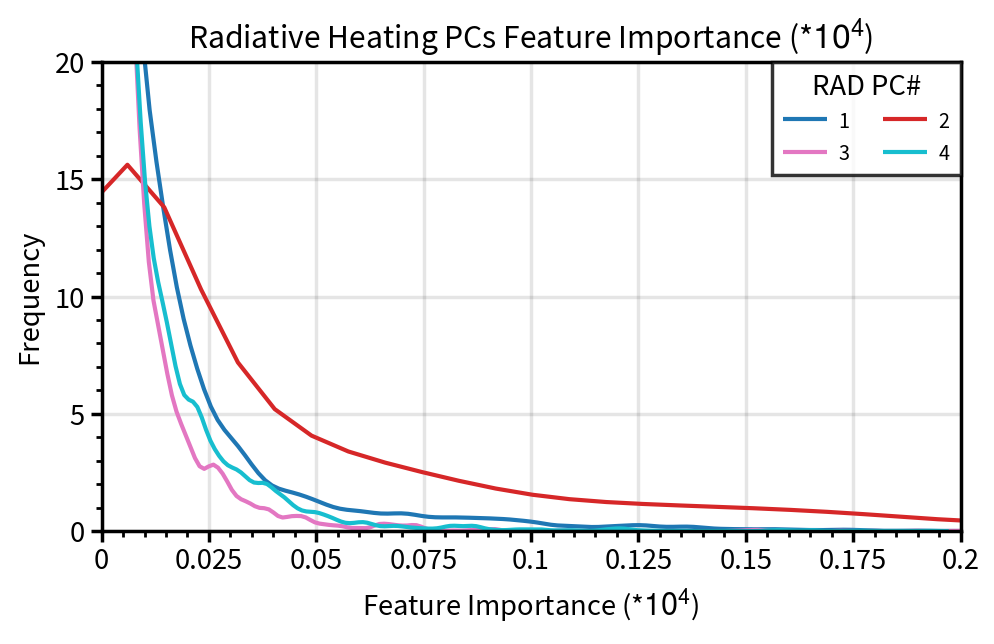

In [85]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

colors=plt.cm.tab10(np.linspace(0, 1, 4))
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(4):
    sns.kdeplot(np.asarray(flatten([allans[index][i] for index in range(4)]))*1e4,color=colors[i],label=i+1)#,log_scale=True)#,cumulative=True)
axs.legend(loc='ur',prop={'size':8},ncols=2,title='RAD PC#')
axs[0].format(xlabel=r'Feature Importance (*$\mathit {10^4}$)',ylabel='Frequency',title='Radiative Heating PCs Feature Importance (*$\mathit {10^4}$)',xlim=[0,0.0002*1e3],ylim=[0,20])
plt.savefig('../../../figures/0707/featureimportance_intermediate.png',dpi=300)
plt.show()

/tmp/ipykernel_2096034/1598844597.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


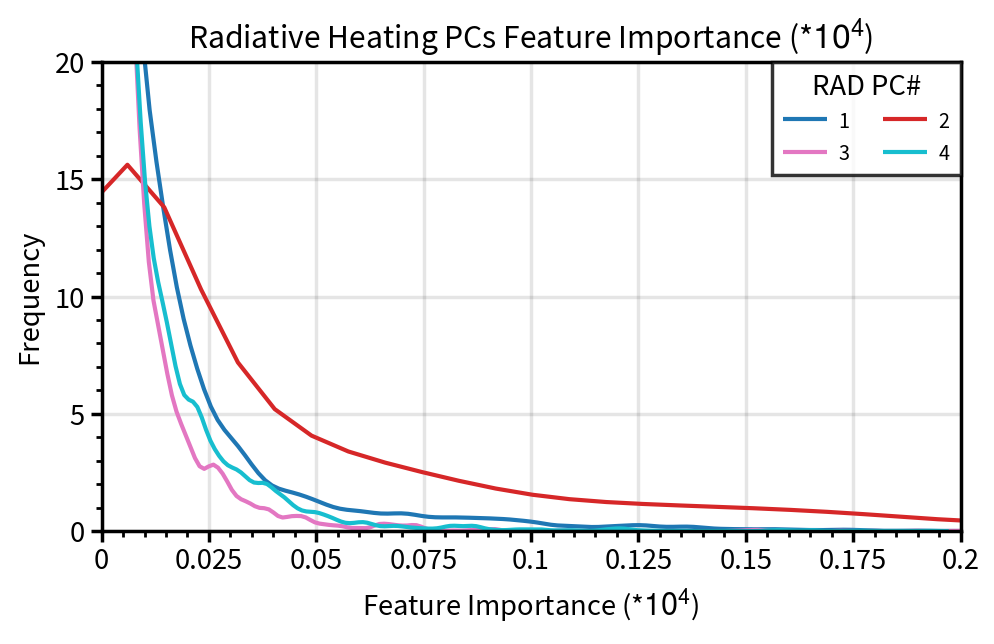

In [20]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

colors=plt.cm.tab10(np.linspace(0, 1, 4))
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(4):
    sns.kdeplot(np.asarray(flatten([allans[index][i] for index in range(4)]))*1e4,color=colors[i],label=i+1)#,log_scale=True)#,cumulative=True)
axs.legend(loc='ur',prop={'size':8},ncols=2,title='RAD PC#')
axs[0].format(xlabel=r'Feature Importance (*$\mathit {10^4}$)',ylabel='Frequency',title='Radiative Heating PCs Feature Importance (*$\mathit {10^4}$)',xlim=[0,0.0002*1e3],ylim=[0,20])
#plt.savefig('../../../figures/0707/featureimportance_intermediate_cross7.png',dpi=300)
plt.show()

In [30]:
len(flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))])+flatten([new_feature_c32[i][0:5] for i in range(len(model_c32))])),len(flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))]))

(165, 75)

In [21]:
len(flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))])+flatten([new_feature_c32[i][0:5] for i in range(len(model_c32))])),len(flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))]))
indexcumsum = np.asarray([26,18,48,14,9,6,4]).cumsum()
print(indexcumsum)

[ 26  44  92 106 115 121 125]


In [28]:
flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))])+flatten([new_feature_c32[i][0:5] for i in range(len(model_c32))])

[108,
 104,
 25,
 103,
 83,
 108,
 27,
 103,
 14,
 83,
 108,
 9,
 25,
 99,
 26,
 108,
 25,
 92,
 106,
 9,
 108,
 1,
 106,
 0,
 9,
 108,
 2,
 94,
 96,
 97,
 108,
 106,
 26,
 100,
 13,
 108,
 25,
 52,
 93,
 14,
 108,
 25,
 52,
 14,
 1,
 108,
 94,
 2,
 25,
 78,
 108,
 111,
 1,
 92,
 112,
 2,
 108,
 106,
 9,
 25,
 108,
 9,
 0,
 99,
 106,
 108,
 25,
 96,
 11,
 77,
 108,
 101,
 96,
 99,
 106,
 108,
 96,
 94,
 9,
 2,
 9,
 104,
 103,
 34,
 108,
 108,
 9,
 106,
 0,
 93,
 108,
 94,
 9,
 92,
 103,
 108,
 2,
 94,
 92,
 101,
 108,
 115,
 9,
 111,
 1,
 92,
 2,
 4,
 26,
 89,
 108,
 2,
 71,
 0,
 94,
 108,
 94,
 2,
 25,
 9,
 108,
 2,
 111,
 98,
 0,
 108,
 9,
 94,
 2,
 63,
 108,
 2,
 94,
 37,
 26,
 108,
 94,
 0,
 25,
 103,
 108,
 111,
 22,
 74,
 63,
 108,
 94,
 104,
 83,
 71,
 108,
 94,
 96,
 2,
 9,
 108,
 9,
 2,
 15,
 26,
 50,
 108,
 94,
 96,
 26]

In [35]:
import pandas as pd
indexcumsum = np.asarray([26,18,48,14,9,6,4]).cumsum()
print(indexcumsum)
alllist = (flatten([new_feature_c3[i][0:5] for i in range(len(model_c3))])+flatten([new_feature_c32[i][0:5] for i in range(len(model_c32))]))
a = pd.Series(alllist).value_counts()

In [91]:
a

108    17
94     11
2      10
9       9
0       4
26      4
96      3
92      3
111     3
103     3
71      2
25      2
104     2
63      2
15      1
83      1
74      1
22      1
37      1
98      1
106     1
93      1
89      1
4       1
1       1
115     1
101     1
34      1
50      1
dtype: int64

In [36]:
a

108    32
9      14
94     13
2      13
25     10
106     7
26      6
96      6
0       6
92      5
103     5
1       4
111     4
99      3
14      3
83      3
104     3
93      2
63      2
71      2
101     2
52      2
78      1
13      1
15      1
74      1
22      1
37      1
27      1
98      1
97      1
89      1
4       1
115     1
34      1
100     1
77      1
11      1
112     1
50      1
dtype: int64

#### R2

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectorMixin
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.model_selection import cross_val_score

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms_intermediate(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(np.nanmean(exp.reshape(exp.shape[0],10,360,208),axis=2).reshape(exp.shape[0],-1),timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        [examplist.pop(i) for i in validindex]
        [examplist.pop(i) for i in testindex]
        return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in (range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in (range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in (range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in (range(1,21))].copy()
        
        if category=='train':
            popindex = validindex+testindex
            ut = [u[i] for i in range(len(u)) if i not in popindex]
            vt = [v[i] for i in range(len(v)) if i not in popindex]
            wt = [w[i] for i in range(len(w)) if i not in popindex]
            thetat = [theta[i] for i in range(len(theta)) if i not in popindex]
            assert len(ut)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms_intermediate(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan'):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        for i in (range(45)):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                mlr_r2.append(a)
            elif case=='Haiyan_axisym':
                temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,208])
                a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2

In [7]:
def output_realdterms(category='train',varnum=None,LT=24,validindex=None,testindex=None):
    if varnum==2:
        a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=LT,forecastPC=None,\
                                     target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                                LT=LT,category=category,validindex=validindex,testindex=testindex)
        return a,b
    elif varnum==4:
        a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=LT,forecastPC=None,\
                                     target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                                LT=LT,category=category,validindex=validindex,testindex=testindex)     
        return a,b,c,d

def separate_realall(vertshape=10,varnum=4,LT=24,validindex=None,testindex=None):
    realdu,realdv,realdw,realdtheta = output_realdterms(category='train',varnum=varnum,LT=LT,validindex=validindex,testindex=testindex)
    realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = output_realdterms(category='valid',varnum=varnum,LT=LT,validindex=validindex,testindex=testindex)
    realdu_test,realdv_test,realdw_test,realdtheta_test = output_realdterms(category='test',varnum=varnum,LT=LT,validindex=validindex,testindex=testindex)
    return {'u':realdu,'v':realdv,'w':realdw,'theta':realdtheta},{'u':realdu_valid,'v':realdv_valid,'w':realdw_valid,'theta':realdtheta_valid},{'u':realdu_test,'v':realdv_test,'w':realdw_test,'theta':realdtheta_test}

In [135]:
train_realUV,valid_realUV,test_realUV = [],[],[]
for i in tqdm([0]):#range(15)):#range(1)):
    tempindex = _get_exp_name(i,3)[1]
    validindex,testindex = [int(tempindex[0]),int(tempindex[1])],[int(tempindex[2]),int(tempindex[3])]
    obj1,obj2,obj3 = separate_realall(vertshape=10,validindex=validindex,testindex=testindex)
    train_realUV.append(obj1)
    valid_realUV.append(obj2)
    test_realUV.append(obj3)
del obj1,obj2,obj3
gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

21

In [134]:
_get_exp_name(0,3)[1]

['10', '16', '1', '4']

#### Read saved files

In [108]:
read_and_proc.save_to_pickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/train_realUV_0_15',train_realUV,'PICKLE')
read_and_proc.save_to_pickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/valid_realUV_0_15',valid_realUV,'PICKLE')
read_and_proc.save_to_pickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/test_realUV_0_15',test_realUV,'PICKLE')

In [9]:
lti=24
model_c3 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/FFWmodels_cross5_0_15')
new_feature_c3 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/newfeature_cross5_0_15')
reducedX_c3 = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/reducedX_cross5_0_15')
train_realUV = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/train_realUV_0_15')
valid_realUV = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/valid_realUV_0_15')
test_realUV = read_and_proc.depickle('../../../output/haiyan/processed/intermediate/pca/FFW/random/'+str(lti)+'/test_realUV_0_15')

In [136]:
#ytest = [yobj[2] for yobj in yall]
#mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xtest['dtthuvw'],ytest)
    
#reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
r2_train = retrieve_cartesian(PCA_dict=pcastore,Af_dict=haiyan_data,numcomp=[26,18,48,14],LT=lti,forecastPC=None,target='all',\
                              suffix=suffix).output_r2(FFWmodels=model_c3[0],reducedX=reducedX_c3[0],realU=train_realUV[0]['u'],realV=train_realUV[0]['v'],realW=train_realUV[0]['w'],realTH=train_realUV[0]['theta'],case='Haiyan')

0.6442758535934598
0.6563269053471205
0.6649164010599167
0.6726408074815261
0.68216315831597
0.6879096512890811
0.690679854582463
0.6966498742072817
0.7047647755881395
0.7150543188699935
0.7175896391200767
0.7259545379678881
0.7299521691684739
0.742625438460015
0.7516062391061008
0.7537261038762614
0.7575560042063936
0.761708767827579
0.7700930113086787
0.771774294806213
0.7755282095149614
0.7794474227160008


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


0.7814161372294551
0.7858277641362437


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


0.7953356512682592
0.7981964578063484


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


0.8000484138739001
0.805011986246003


distributed.utils_perf - WARNING - full garbage collections took 85% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8080936277286842
0.8130119741521918


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8209766645377635
0.8231687759599984


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8258074456860087
0.8359307949719047


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8373712909265087
0.8395799039816618


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8435709326597539
0.8467294802472414


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.850450337429244
0.8550702030264399


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8569251940146474
0.8593277956051673


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8617181281799068
0.8654232234446688


distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 89% CPU time recently (threshold: 10%)


0.8668918502739685


In [34]:
class _get_r2:
    def __init__(self,pcadict=None,afdict=None,numcomp=None,LT=None,FFWmodel=None,reducedX=None,realVARS=None,case='Haiyan_axisym'):
        self.pcadict=pcadict
        self.afdict=afdict
        self.numcomp=numcomp
        self.lti=LT
        self.FFWmodel=FFWmodel
        self.reducedX=reducedX
        self.realvar = realVARS
        self.case = case
        
    def _get_trainR2(self):
        return [retrieve_cartesian(PCA_dict=self.pcadict,Af_dict=self.afdict,numcomp=self.numcomp,LT=self.lti,forecastPC=None,target='all',\
                              suffix=suffix).output_r2(FFWmodels=self.FFWmodel[i],reducedX=self.reducedX[i],realU=self.realvar[i]['u'],realV=self.realvar[i]['v'],realW=self.realvar[i]['w'],realTH=self.realvar[i]['theta'],case=self.case)
               for i in tqdm(range(len(self.FFWmodel)))]
    
    def _get_validR2(self,X=None,y=None,locselected=[121,122,123,124],newfeature=None):
        def _get_loopfeature(X=None,y=None,timeindx=None):
            yvalid = [yobj[1] for yobj in y[timeindx]]
            mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=self.lti,auxIN=None).transform(X[timeindx]['dtthuvwqv'],yvalid)
            loopfeature = [np.asarray(locselected.copy())]
            for i in range(len(newfeature[timeindx])):
                loopfeature.append(np.append(loopfeature[i],newfeature[timeindx][i]))
            return loopfeature,mlrIN_v,mlrOUT_v
        r2store = []
        for i in range(len(self.FFWmodel)):
            loopfeature,mlrIN_v,_ = _get_loopfeature(X,y,i)
            reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
            r2_train = retrieve_cartesian(PCA_dict=self.pcadict,Af_dict=self.afdict,numcomp=self.numcomp,LT=self.lti,forecastPC=None,target='all',\
                                          suffix=suffix).output_r2(FFWmodels=self.FFWmodel[i],reducedX=reducedX_test[1:],realU=self.realvar[i]['u'],realV=self.realvar[i]['v'],realW=self.realvar[i]['w'],realTH=self.realvar[i]['theta'],
                                                                   case=self.case)
            r2store.append(r2_train)
        return r2store
            
    def _get_testR2(self,X=None,y=None,locselected=[121,122,123,124],newfeature=None):
        def _get_loopfeature(X=None,y=None,timeindx=None):
            yvalid = [yobj[2] for yobj in y[timeindx]]
            mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=self.lti,auxIN=None).transform(X[timeindx]['dtthuvwqv'],yvalid)
            loopfeature = [np.asarray(locselected.copy())]
            for i in range(len(newfeature[timeindx])):
                loopfeature.append(np.append(loopfeature[i],newfeature[timeindx][i]))
            return loopfeature,mlrIN_v,mlrOUT_v
        r2store = []
        for i in range(len(self.FFWmodel)):
            loopfeature,mlrIN_v,_ = _get_loopfeature(X,y,i)
            reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
            r2_train = retrieve_cartesian(PCA_dict=self.pcadict,Af_dict=self.afdict,numcomp=self.numcomp,LT=self.lti,forecastPC=None,target='all',\
                                          suffix=suffix).output_r2(FFWmodels=self.FFWmodel[i],reducedX=reducedX_test[1:],realU=self.realvar[i]['u'],realV=self.realvar[i]['v'],realW=self.realvar[i]['w'],realTH=self.realvar[i]['theta'],
                                                                   case=self.case)
            r2store.append(r2_train)
        return r2store

In [21]:
r2train = _get_r2(pcastore,haiyan_data,[26,18,48,14],24,model_c3,reducedX_c3,train_realUV,'Haiyan_axisym')._get_trainR2()

  0%|          | 0/15 [00:00<?, ?it/s]

distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [36]:
r2valid = _get_r2(pcastore,haiyan_data,[26,18,48,14],24,model_c3,reducedX_c3,valid_realUV,'Haiyan_axisym')._get_validR2(Xvalid,yall,[121,122,123,124],new_feature_c3)
r2test = _get_r2(pcastore,haiyan_data,[26,18,48,14],24,model_c3,reducedX_c3,test_realUV,'Haiyan_axisym')._get_testR2(Xtest,yall,[121,122,123,124],new_feature_c3)

distributed.utils_perf - WARNING - full garbage collections took 88% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 88% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 88% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 88% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 88% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 88% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 88% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 87% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 87% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [13]:
yvalid = [yobj[1] for yobj in yall[0]]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xvalid[0]['dtthuvwqv'],yvalid)

loc = [121,122,123,124]#[int(obj) for obj in list(np.transpose(np.linspace(269,289-1,20)))]
loopfeature = [np.asarray(loc.copy())]
for i in range(len(new_feature_c3[timeid])):
    loopfeature.append(np.append(loopfeature[i],new_feature_c3[timeid][i]))
    
#reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
#r2_train = retrieve_cartesian(PCA_dict=pcastore,Af_dict=haiyan_data,numcomp=[26,18,48,14],LT=lti,forecastPC=None,target='all',\
#                              suffix=suffix).output_r2(FFWmodels=model_c3[0],reducedX=reducedX_test[1:],realU=valid_realUV[0]['u'],realV=valid_realUV[0]['v'],realW=valid_realUV[0]['w'],realTH=valid_realUV[0]['theta'],case='Haiyan')

/tmp/ipykernel_549934/272970323.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


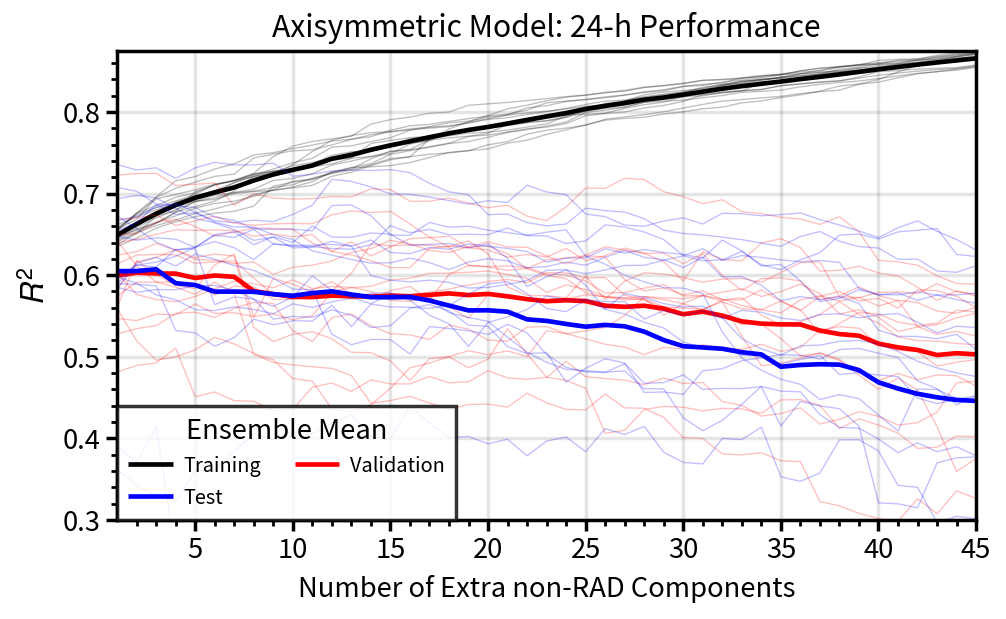

distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


In [63]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for i in range(len(r2train)):
    axs[0].plot(np.linspace(1,45,45),r2train[i],alpha=0.25,lw=0.48,c='k')
axs[0].plot(np.linspace(1,45,45),np.nanmean(np.asarray(r2train),axis=0),lw=1.68,c='k',label='Training')
for i in range(len(r2valid)):
    axs[0].plot(np.linspace(1,45,45),r2valid[i],alpha=0.25,lw=0.48,c='r')
axs[0].plot(np.linspace(1,45,45),np.nanmean(np.asarray(r2valid),axis=0),lw=1.68,c='r',label='Validation')
for i in range(len(r2test)):
    axs[0].plot(np.linspace(1,45,45),r2test[i],alpha=0.25,lw=0.48,c='b')
axs[0].plot(np.linspace(1,45,45),np.nanmean(np.asarray(r2test),axis=0),lw=1.68,c='b',label='Test')
axs[0].format(ylim=[0.3,0.875],xlabel=r'Number of Extra non-RAD Components',ylabel='$\mathit {R^2}$',title='Axisymmetric Model: 24-h Performance')
axs.legend(loc='ll',prop={'size':8},ncols=2,title='Ensemble Mean')
plt.savefig('../../../figures/0707/intermediate_0_15_r2.png',dpi=300)
plt.show()